# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
pandarallel.initialize()



INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
negative_words = [
    "bad", "poor", "terrible", "disappointing", "awful", "worst", "horrible", "unreliable", "waste", 
    "garbage", "junk", "cheap", "flimsy", "broken", "useless", "defective", "faulty", "fake", "boring",
    "dull", "slow", "overpriced", "lame", "unwatchable", "predictable", "annoying", "inconsistent",
    "ridiculous", "mediocre", "unrealistic", "forgettable", "underwhelming", "unconvincing", "cliché",
    "overrated", "overdone", "painful", "lengthy", "disgusting", "frustrating", "repetitive", "predictable",
    "awkward", "cringe", "stupid", "hated", "inadequate", "pointless", "gross", "unpleasant", "disturbing",
    "misleading", "regret", "boring", "lazy", "dated", "clunky", "dysfunctional", "cheaply-made",
    "underdeveloped", "forgettable", "shallow", "weak", "annoyed", "unpolished", "horrendous", "unappealing",
    "lackluster", "problematic", "flawed", "annoy", "predictable", "cheesy", "cringe", "unbelievable",
    "nonsense", "overblown", "confusing", "shoddy", "stiff", "exaggerated", "excessive", "worthless",
    "unacceptable", "pathetic", "crappy", "sucks", "sucked", "shit", "bullshit", "crap", "damn", "damned",
    "fucking", "fuck", "hell", "pissed", "ass", "bastard", "idiot", "idiotic", "dumb", "moron", "trash",
    "shitty", "fucked", "loser", "garbage", "pathetic", "disgusted", "repulsive", "abysmal", "horrid",
    "gross", "foul", "atrocious", "miserable", "deplorable", "scam", "rip-off", "useless", "failure"
]

neutral_words = [
    "average", "okay", "fine", "decent", "standard", "basic", "sufficient", 
    "acceptable", "moderate", "typical", "ordinary", "regular", "normal", 
    "adequate", "functional", "usable", "workable", "plain", "fair", 
    "serviceable", "similar", "comparable", "parallel", "equal", "equivalent",
    "unremarkable", "uninspired", "plain", "middle", "middling", 
    "intermediate", "recent", "current", "ongoing", "modern", "medium", 
    "average-sized", "mid-sized", "standard-sized", "several", "some", 
    "a few", "various", "manageable", "satisfactory", "sufficient", 
    "adequate", "mild", "moderate", "restrained", "controlled", 
    "limited", "steady", "indifferent", "unbiased", "objective", "neutral", 
    "balanced", "consistent", "predictable", "stable", "even", "balanced",
    "usual", "customary", "routine", "normal", "regular"
]



# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

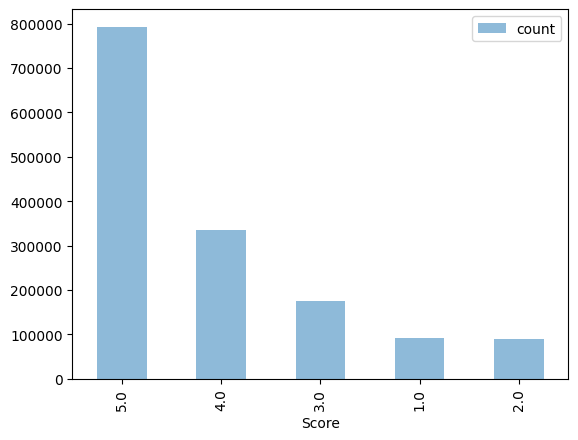


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [53]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Ensure the 'Text' column has no non-string values (replace NaN or float with an empty string)
    df['Text'] = df['Text'].fillna('').astype(str)

    # Add VADER Sentiment Score (compound) as a continuous feature
    df['VADER_Sentiment'] = df['Text'].parallel_apply(lambda x: analyzer.polarity_scores(x)['compound'])
    
    # Add Predicted Sentiment (binary) as a feature
    df['Predicted_Sentiment'] = df['VADER_Sentiment'].parallel_apply(lambda score: 1 if score > 0 else 0)

    df['Negative_Word_Count'] = df['Text'].parallel_apply(lambda x: sum(1 for word in x.split() if word.lower() in negative_words))

    df['Sample_Weight'] = df['Negative_Word_Count'].parallel_apply(lambda x: 2 if x > 0 else 1)


    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

In [54]:
X_train['Predicted_Negative'] = X_train['VADER_Sentiment'].parallel_apply(lambda x: 1 if x < -0.3 else 0)
X_train['Predicted_Neutral'] = X_train['VADER_Sentiment'].parallel_apply(lambda x: 1 if -0.3 <= x <= 0.3 else 0)
X_train['Predicted_Positive'] = X_train['VADER_Sentiment'].parallel_apply(lambda x: 1 if x > 0.3 else 0)

X_submission['Predicted_Negative'] = X_submission['VADER_Sentiment'].parallel_apply(lambda x: 1 if x < -0.3 else 0)
X_submission['Predicted_Neutral'] = X_submission['VADER_Sentiment'].parallel_apply(lambda x: 1 if -0.3 <= x <= 0.3 else 0)
X_submission['Predicted_Positive'] = X_submission['VADER_Sentiment'].parallel_apply(lambda x: 1 if x > 0.3 else 0)

X_train['Helpfulness_Squared'] = X_train['Helpfulness'] ** 2
X_submission['Helpfulness_Squared'] = X_submission['Helpfulness'] ** 2

X_train['Review_Length'] = X_train['Text'].apply(lambda x: len(str(x).split()))
X_submission['Review_Length'] = X_submission['Text'].apply(lambda x: len(str(x).split()))

X_train['Length_Sentiment_Product'] = X_train['Review_Length'] * X_train['VADER_Sentiment']
X_submission['Length_Sentiment_Product'] = X_submission['Review_Length'] * X_submission['VADER_Sentiment']

X_train['Text'] = X_train['Text'].fillna('').astype(str)
X_submission['Text'] = X_submission['Text'].fillna('').astype(str)

X_train['Neutral_Word_Count'] = X_train['Text'].apply(lambda x: sum(1 for word in x.split() if word.lower() in neutral_words))
X_submission['Neutral_Word_Count'] = X_submission['Text'].apply(lambda x: sum(1 for word in x.split() if word.lower() in neutral_words))

X_train['Helpfulness_Sentiment_Product'] = X_train['Helpfulness'] * X_train['VADER_Sentiment']
X_submission['Helpfulness_Sentiment_Product'] = X_submission['Helpfulness'] * X_submission['VADER_Sentiment']

print(X_train.columns)
print(X_submission.columns)

Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness', 'VADER_Sentiment', 'Predicted_Sentiment',
       'Negative_Word_Count', 'Sample_Weight', 'Predicted_Negative',
       'Predicted_Neutral', 'Predicted_Positive', 'Helpfulness_Squared',
       'Review_Length', 'Length_Sentiment_Product', 'Neutral_Word_Count',
       'Helpfulness_Sentiment_Product'],
      dtype='object')
Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Helpfulness',
       'VADER_Sentiment', 'Predicted_Sentiment', 'Negative_Word_Count',
       'Sample_Weight', 'Score', 'Predicted_Negative', 'Predicted_Neutral',
       'Predicted_Positive', 'Helpfulness_Squared', 'Review_Length',
       'Length_Sentiment_Product', 'Neutral_Word_Count',
       'Helpfulness_Sentiment_Product'],
      dtype='object')


In [44]:
if 'Score' in X_train.columns:
    print("The 'Score' column is in X_train.")
else:
    print("The 'Score' column is not in X_train.")


The 'Score' column is in X_train.


# Sample + Split into training and testing set

In [55]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [56]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time',
       'Helpfulness_Squared', 'VADER_Sentiment', 'Predicted_Sentiment',
       'Negative_Word_Count', 'Sample_Weight', 'Predicted_Negative',
       'Predicted_Neutral', 'Predicted_Positive', 'Neutral_Word_Count',
       'Review_Length', 'Length_Sentiment_Product', 'Helpfulness_Sentiment_Product']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Scale the data for knn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_select)
X_test_scaled = scaler.transform(X_test_select)
X_submission_scaled = scaler.transform(X_submission_select)


# Model Creation

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_knn = KNeighborsClassifier(n_neighbors=50).fit(X_train_scaled, Y_train)
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42).fit(X_train_scaled, Y_train)
model_logreg = LogisticRegression(class_weight='balanced', C=0.1, max_iter=1000, random_state=42).fit(X_train_scaled, Y_train)  # C=0.1 applies L2 regularization.fit(X_train, Y_train)

Y_test_predictions_knn = model_knn.predict(X_test_scaled)
Y_test_predictions_rf = model_rf.predict(X_test_select)
Y_test_predictions_logreg = model_logreg.predict(X_test_scaled)


c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy on testing set =  0.520288902772691


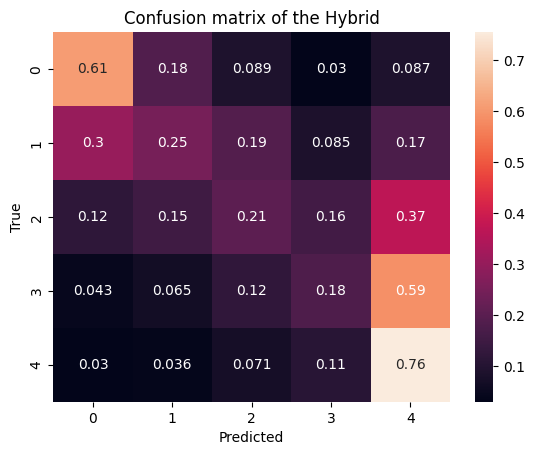

In [75]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Step 1: Create binary labels for KNN (5-star = 1, not 5-star = 0)
Y_train_binary = Y_train.apply(lambda x: 1 if x == 5 else 0)
Y_test_binary = Y_test.apply(lambda x: 1 if x == 5 else 0)

# Step 2: Train KNN to identify 5-star reviews
knn_model = KNeighborsClassifier(n_neighbors=50)
knn_model.fit(X_train_scaled, Y_train_binary)

# Step 3: Train Logistic Regression for 0-4 stars on non-5-star data
# Filter data to exclude 5-star reviews
X_train_non_5 = X_train_scaled[Y_train != 5]
Y_train_non_5 = Y_train[Y_train != 5]
X_test_non_5 = X_test_scaled[Y_test != 5]
Y_test_non_5 = Y_test[Y_test != 5]

logistic_model = LogisticRegression(class_weight='balanced', C=0.1, max_iter=1000, random_state=42)
logistic_model.fit(X_train_non_5, Y_train_non_5)

# Step 4: Make predictions
def hybrid_predict(X):
    # First, use KNN to predict if the review is 5 stars
    knn_pred = knn_model.predict(X)
    
    # For reviews not classified as 5-star, use Logistic Regression
    logistic_pred = logistic_model.predict(X)
    
    # Combine predictions: if KNN predicts 5-star, use that; otherwise, use Logistic Regression prediction
    final_pred = [5 if knn == 1 else log for knn, log in zip(knn_pred, logistic_pred)]
    return final_pred

# Get predictions on test data
Y_test_predictions = hybrid_predict(X_test_scaled)

print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the Hybrid')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Model Evaluation

Accuracy on testing set =  0.5598379903914514


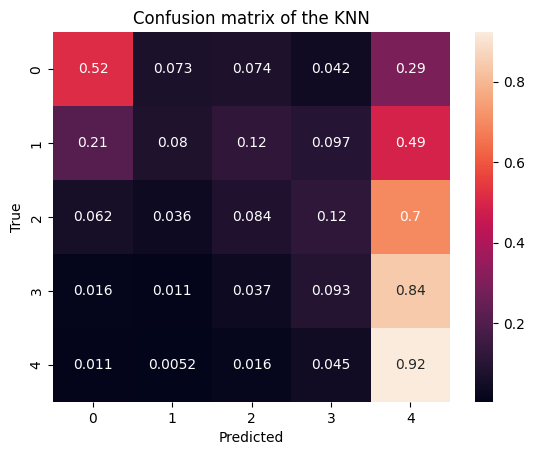

In [68]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions_knn))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions_knn, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy on testing set =  0.5017235064739212


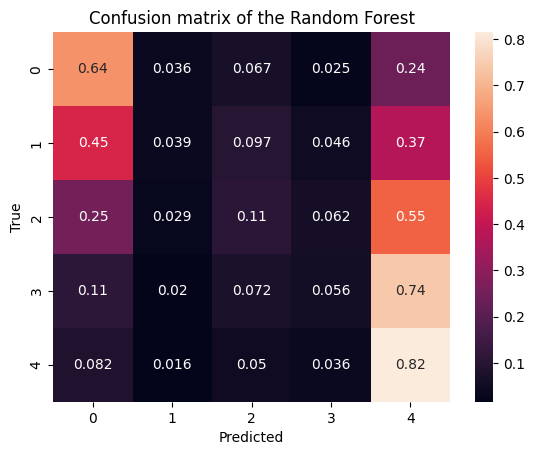

In [69]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions_rf))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions_rf, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy on testing set =  0.48572990499170565


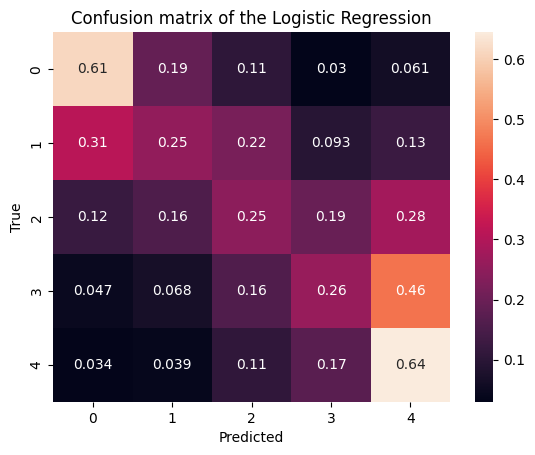

In [70]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions_logreg))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions_logreg, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [72]:
# Create the submission file
X_submission['Score'] = model_knn.predict(X_submission_scaled)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)
print("submission.csv shape is ", submission.shape)


submission.csv shape is  (212192, 2)


In [76]:
# Create the submission file
X_submission['Score'] = model_logreg.predict(X_submission_scaled)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission_logreg.csv", index=False)



In [77]:
# Create the submission file
X_submission['Score'] = model_rf.predict(X_submission_scaled)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submissionrf.csv", index=False)



In [78]:
# Create the submission file
X_submission['Score'] = hybrid_predict(X_submission_scaled)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submissionhybrid.csv", index=False)